In [1]:
import cv2
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix
import re
import gc
import os
import glob
import keras
import pandas as pd
import numpy  as np
import itertools
from sklearn.metrics import confusion_matrix
from collections import Counter
import keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [93]:
batch_size = 128
epochs = 20
pic_size = 48
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
datagen_train  = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
datagen_val = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

In [4]:
train_set = datagen_train.flow_from_directory(r"C:\Users\HP\Documents\Machine project\images\images\train", 
                                              target_size = (pic_size,pic_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


val_set = datagen_val.flow_from_directory(r"C:\Users\HP\Documents\Machine project\images\images\validation",
                                              target_size = (pic_size,pic_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

counter = Counter(train_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  

Found 27658 images belonging to 7 classes.
Found 6714 images belonging to 7 classes.


In [5]:
model = Sequential()
model.add(EfficientNetB0(input_shape=(pic_size, pic_size, 3), weights='imagenet', include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.25))
model.add(Dense(7,activation='softmax'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 2, 2, 1280)       4049571   
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 7)                 8967      
                                                                 
Total params: 4,058,538
Trainable params: 4,016,515
Non-trainable params: 42,023
_________________________________________________________________


In [8]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )
checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')


callbacks_list = [early_stopping,checkpoint]




In [11]:
history = model.fit(train_set, 
                    validation_data = val_set,
                    class_weight=class_weights,
                    epochs = epochs,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                   validation_steps = val_set.n//val_set.batch_size,callbacks=callbacks_list)

Epoch 1/20
216/216 [==============================] - 357s 2s/step - loss: 3.8349 - accuracy: 0.2142 - val_loss: 2.0159 - val_accuracy: 0.2580
Epoch 2/20
216/216 [==============================] - 373s 2s/step - loss: 2.8816 - accuracy: 0.3217 - val_loss: 1.9204 - val_accuracy: 0.2846
Epoch 3/20
216/216 [==============================] - 359s 2s/step - loss: 2.4720 - accuracy: 0.3870 - val_loss: 1.6459 - val_accuracy: 0.3900
Epoch 4/20
216/216 [==============================] - 359s 2s/step - loss: 2.2177 - accuracy: 0.4356 - val_loss: 1.5174 - val_accuracy: 0.4354
Epoch 5/20
216/216 [==============================] - 358s 2s/step - loss: 1.9969 - accuracy: 0.4821 - val_loss: 1.4526 - val_accuracy: 0.4543
Epoch 6/20
216/216 [==============================] - 361s 2s/step - loss: 1.8411 - accuracy: 0.5222 - val_loss: 1.4132 - val_accuracy: 0.4754
Epoch 7/20
216/216 [==============================] - 359s 2s/step - loss: 1.6790 - accuracy: 0.5555 - val_loss: 1.3763 - val_accuracy: 0.4860

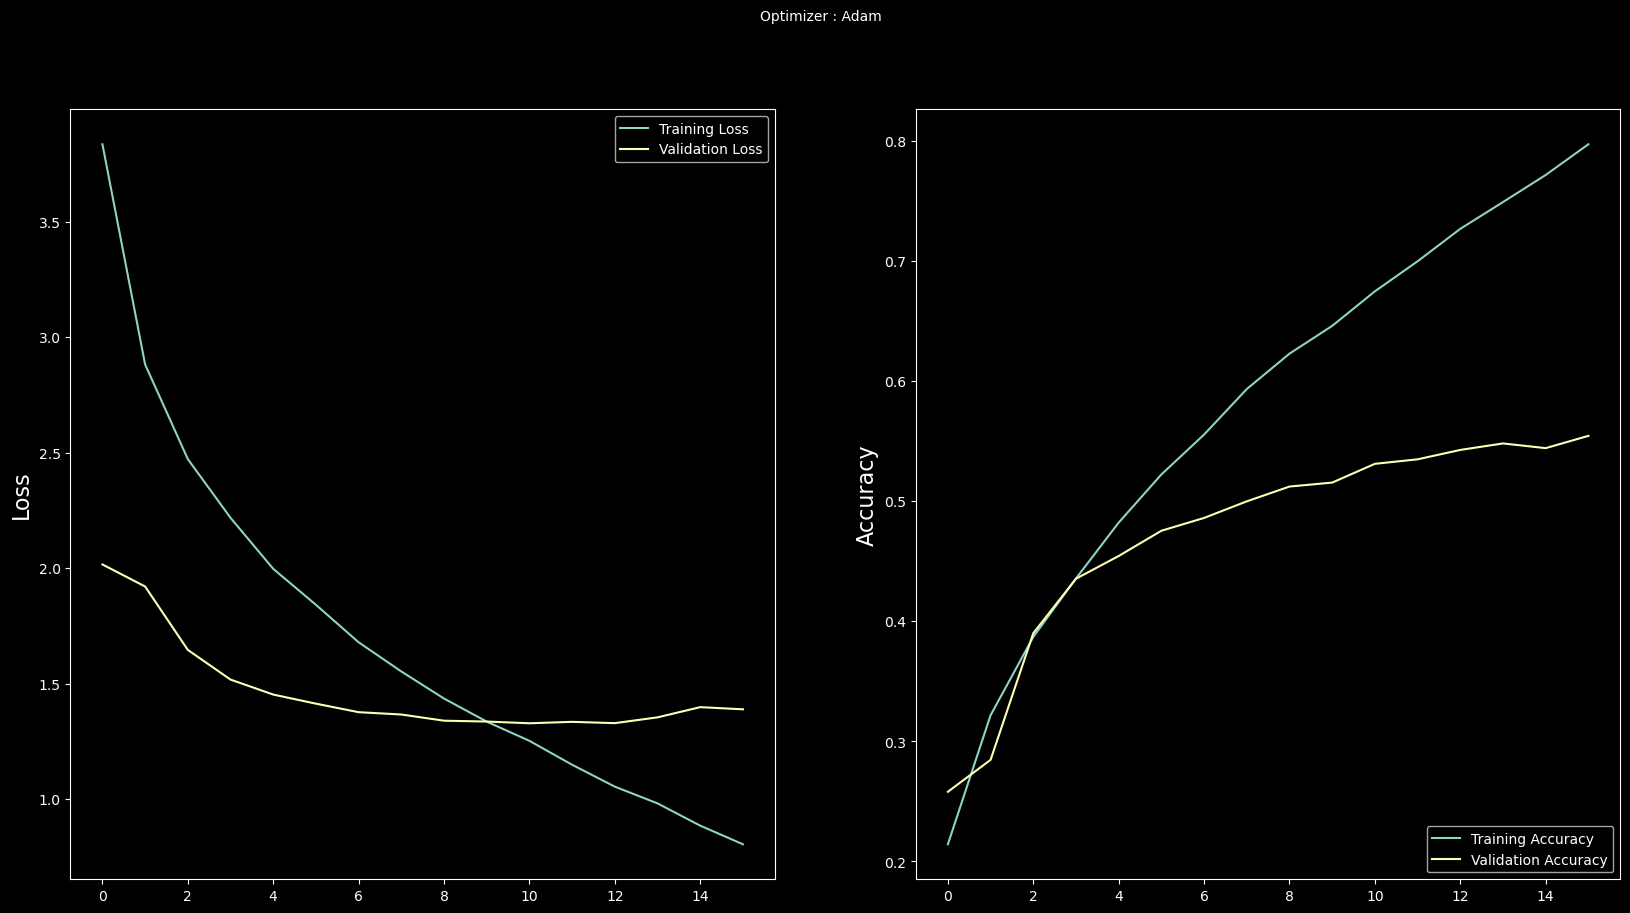

In [138]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_2536\227128211.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator=val_set)


<Figure size 640x480 with 0 Axes>

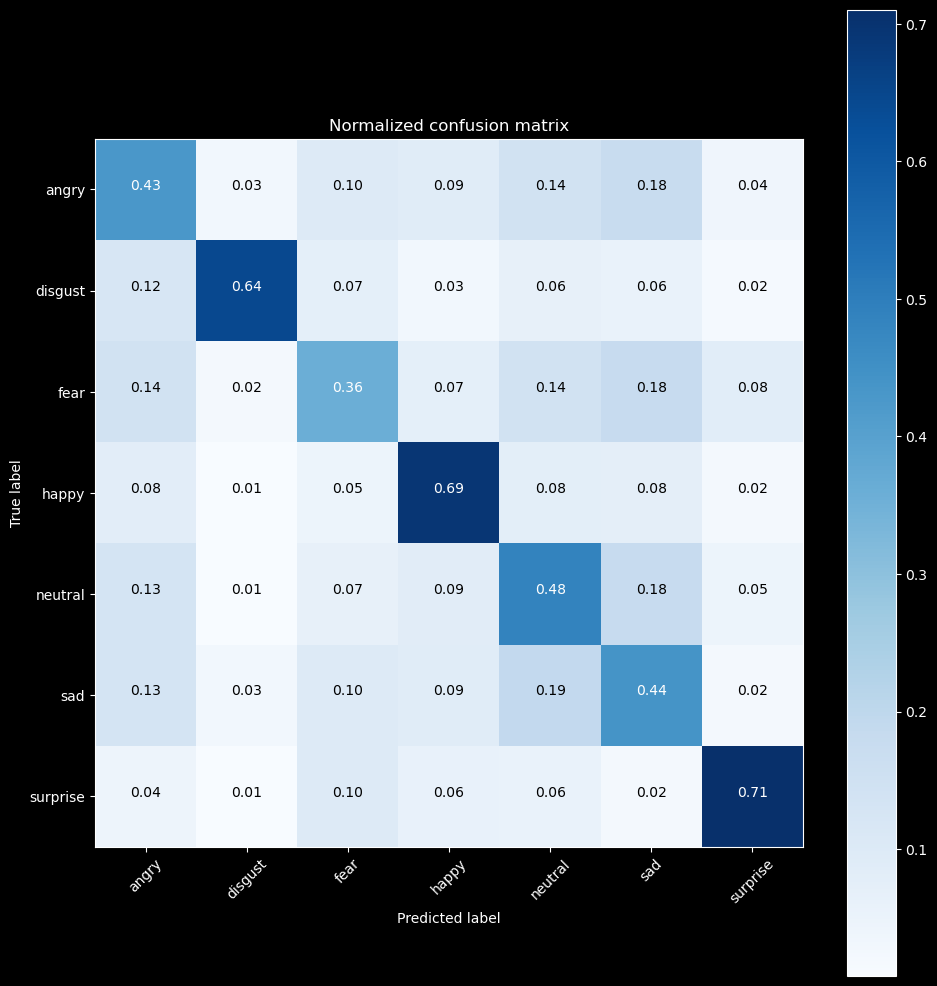

In [139]:
predictions = model.predict_generator(generator=val_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = val_set.classes
class_names = val_set.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

(48, 48)


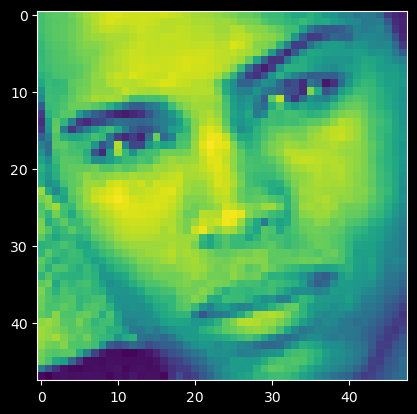

In [142]:
img = image.load_img(r"C:\Users\HP\Documents\Machine project\test\neutral\PrivateTest_3655256.jpg",target_size = (48,48), color_mode="grayscale")
img= np.array(img)
plt.imshow(img)
print(img.shape)

In [143]:
label_dict= {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [144]:
img = np.expand_dims(img,axis = 0)
img = img.reshape (1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

1/1 [==============================] - 0s 69ms/step
[0.07013733, 0.00970325, 0.25539216, 0.0037518619, 0.4469537, 0.15760669, 0.05645497]


In [145]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Neutral
